# Year of birth prediction : comparison between Random Forest and Neural Network regressors

Input data : (2000000, 5)  
  
**Features** :
* *yob* (int, 85 values)
* *domain* (str, 43 values)
* *firstname* (str, 15682 values)
* *zipcode* (int, 2316 values)
* *gender* (str, 3 values)

**Goal** : predict missing yob (year of birth) values and gender values

**Approach** :
* Dimensionality reduction (via clustering)  
* Encoding (one-hot-encoding and label encoding)  
* Regression model (Random Forest and Neural Network)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from random import sample
from scipy import stats
import math
import random

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers import Dense

In [2]:
%matplotlib inline

## Data loading and preprocessing

In [3]:
df = pd.read_csv('user_exo_2M.csv')

df['zipcode'] = df['zipcode']
df['yob'].replace({-1: None}, inplace=True)
df['yob'] = df['yob'].astype('Int64')
df['gender'].replace({pd.NA: 'N/A'}, inplace=True)

features = df.columns

yobs = df['yob'].unique()
domains = df['domain'].unique()
firstnames = df['firstname'].unique()
zipcodes = df['zipcode'].unique()
genders = df['gender'].unique()

display(df)

,yob,domain,firstname,zipcode,gender
0,1985,@wanadoo.fr,b08253b305fb5ec,94450.0,F
1,1961,@sfr.fr,7ff135854376850,78580.0,M
2,1977,@free.fr,172522ec1028ab7,62640.0,N/A
3,<NA>,@hotmail.com,d3ca5dde60f88db,94100.0,M
4,<NA>,@gmail.com,bdaae16837dd576,78100.0,N/A
...,...,...,...,...,...
1999995,1994,@gmail.com,09f96867a8dc816,62400.0,F
1999996,1997,@gmail.com,823fec7a2632ea7,7200.0,M
1999997,1998,@gmail.com,029f0f59eba0903,21000.0,N/A
1999998,<NA>,@hotmail.com,deb97a759ee7b8b,26240.0,M


## Handling missing gender values

''

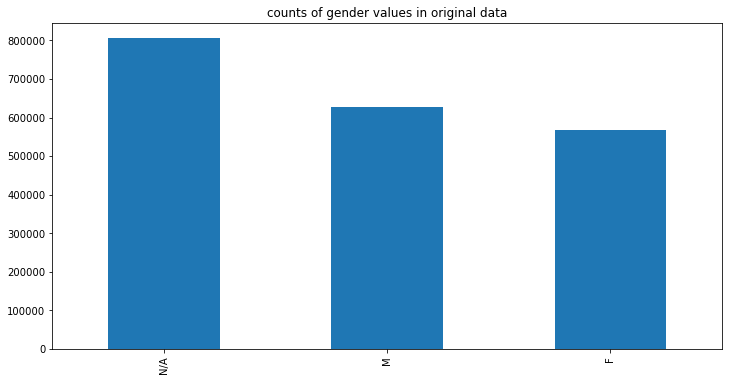

In [4]:
plt.figure(figsize=(12,6))
df['gender'].value_counts().plot(kind='bar')
plt.title('counts of gender values in original data')
;

Most of the values of gender are N/A. For  each firstname, we will pick the most frequent according actual gender (M or F) and update our dataframe with it.

In [6]:
new = df.copy()

for i,firstname in enumerate(firstnames):
    genders_ = list(df[df['firstname']==firstname]['gender'].value_counts().index)
    
    try:
        genders_.remove('N/A')
    except:
        pass
    
    if len(genders_) > 0:
        gender = genders_[0]
    else:
        gender = 'N/A'
        
    new.loc[new['firstname'] == firstname, 'gender'] = gender
new.to_csv('new.csv', index=False)

KeyboardInterrupt: 

Updated gender feature:

In [228]:
df = pd.read_csv('new.csv')
display(df.gender.value_counts())

F    1002529
M     996475
Name: gender, dtype: int64

There are no more N/A values in our dataframe.

## Data Exploration

### Descriptive Statistics

count    1.200000e+06
mean     1.975999e+03
std      1.492501e+01
min      1.900000e+03
25%      1.967000e+03
50%      1.979000e+03
75%      1.988000e+03
max      1.999000e+03
Name: yob, dtype: float64

''

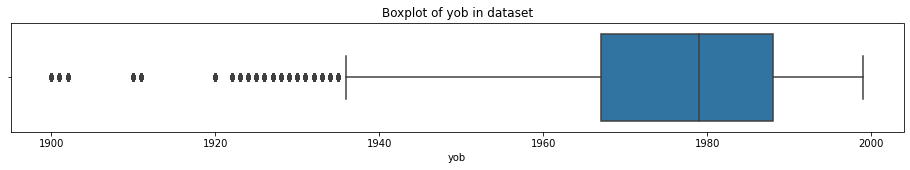

In [8]:
display(df['yob'].describe())

plt.figure(figsize=(16,2))
df['yob'].describe()
sns.boxplot(df['yob'])
plt.title('Boxplot of yob in dataset')
;

Most of our data in included between 1935 and 2000. We have outliers between 1920 and 1935, and some more around 1900.

Overrepresented years in dataset:


1985.0    40116
1990.0    36679
1988.0    35236
1987.0    35120
Name: yob, dtype: int64

''

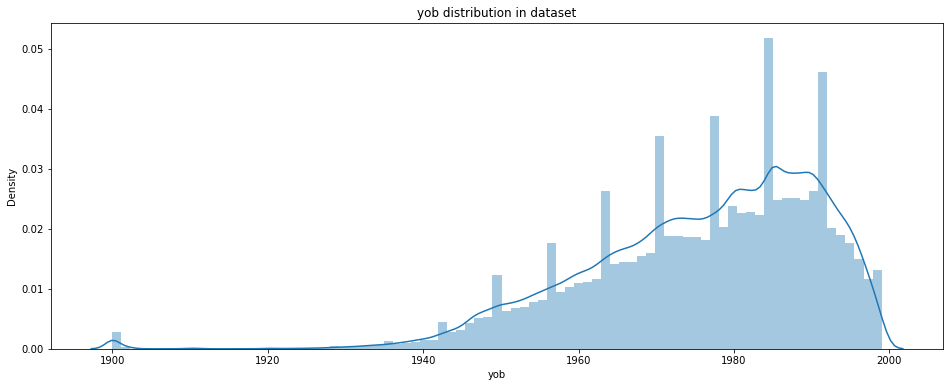

In [9]:
print('Overrepresented years in dataset:')
display(df['yob'].value_counts().iloc[:4])

plt.figure(figsize=(16,6))
sns.distplot(df['yob'], bins=len(yobs))
plt.title('yob distribution in dataset')
;

A few years are overrepresented (especially 1985, 1990, 1988, 1987)

''

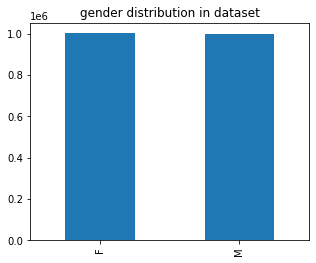

In [10]:
plt.figure(figsize=(5,4))
df['gender'].value_counts().plot(kind='bar')
plt.title('gender distribution in dataset')
;

We have the same amount of both men and women after assigning genders to N/A values.

75015.0    10131
75018.0     7909
51100.0     7907
75020.0     7768
75019.0     7694
           ...  
57370.0      272
38850.0      268
33550.0      263
78590.0      261
33660.0      246
Name: zipcode, Length: 2315, dtype: int64

''

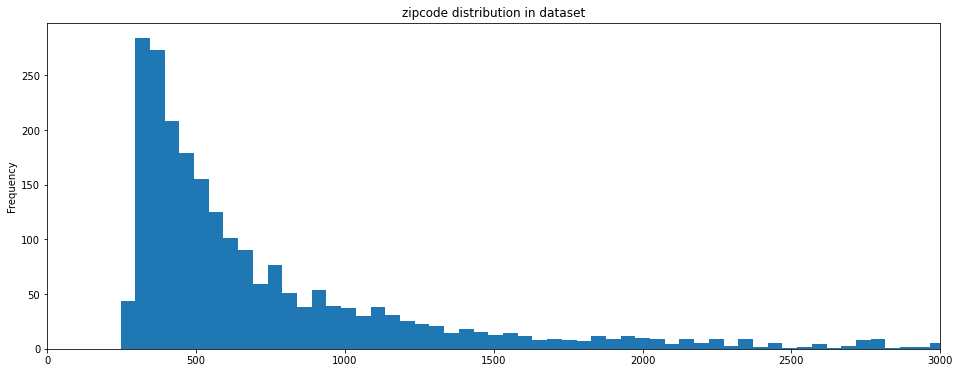

In [11]:
display(df['zipcode'].value_counts())
plt.figure(figsize=(16,6))
df['zipcode'].value_counts().plot(kind='hist', bins=200)
plt.title('zipcode distribution in dataset')
plt.xlim([0, 3000])
;

We have 2315 differents values of zipcodes. This seems a lot, and we might need to reduce it using dimensionality reduction for our ML algorithm(s).

### Bidimensional analysis

Now that he have done a first unidimensional analysis, let's do a 2D one.

''

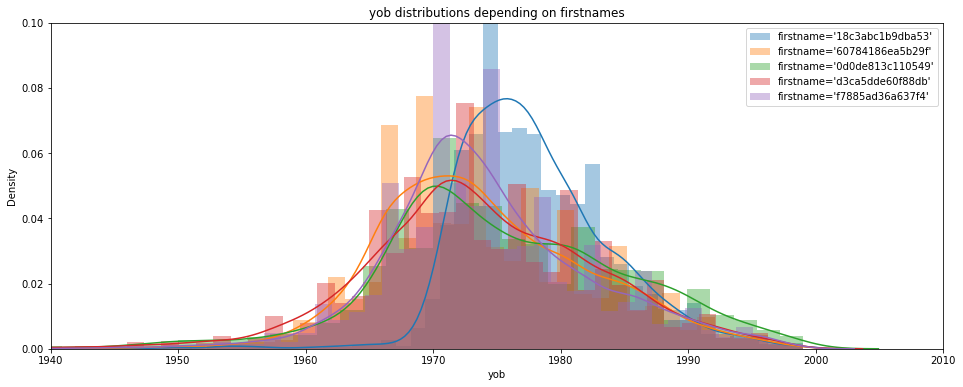

In [12]:
plt.figure(figsize=(16,6))
for firstname in random.sample(list(firstnames[:20]), 5):
    sns.distplot(df[(df['firstname']==firstname) & (df['yob'] >= 1930)]['yob'].dropna(), label=f'{firstname=}')
plt.title('yob distributions depending on firstnames')
plt.xlim([1940, 2010])
plt.ylim([0, 0.10])
plt.legend()
;

We plot the yob distribution for different firstnames. We conclude that the firstname feature is very important and contains a lot of information on the year of birth. In fact, it is obvious that having an old first name generally implies being old and thus having a low value of yob, and having a recent first name means having a higher value of yob.

Let's now see if the domain name contains as much information as the firstname. Our intuition would lead us to say yes, since some domain names are much older than some other recent ones.

''

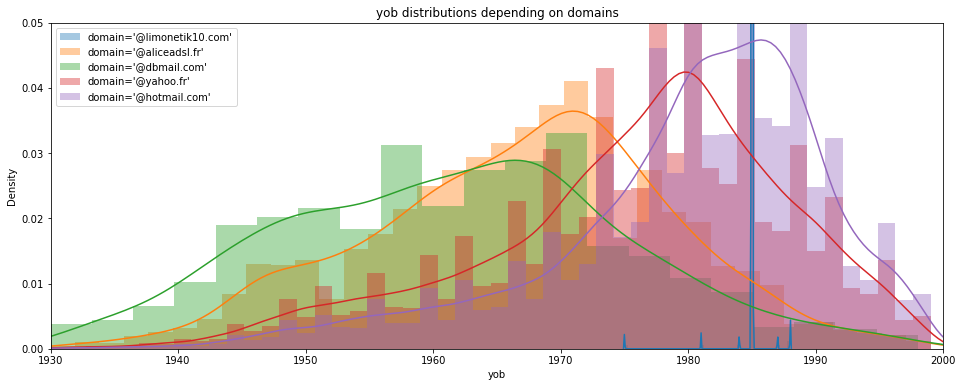

In [13]:
plt.figure(figsize=(16,6))
for domain in random.sample(list(domains), 5):
    sns.distplot(df[(df['domain']==domain) & (df['yob'] >= 1930)]['yob'].dropna(), label=f'{domain=}')
plt.title('yob distributions depending on domains')
plt.xlim([1930, 2000])
plt.ylim([0, 0.05])
plt.legend()
;

As expected, some domain names correspond to younger people. Though, many domains behave in the same way, so we might do a dimension reduction (cluster feature) for our ML algorithm.

''

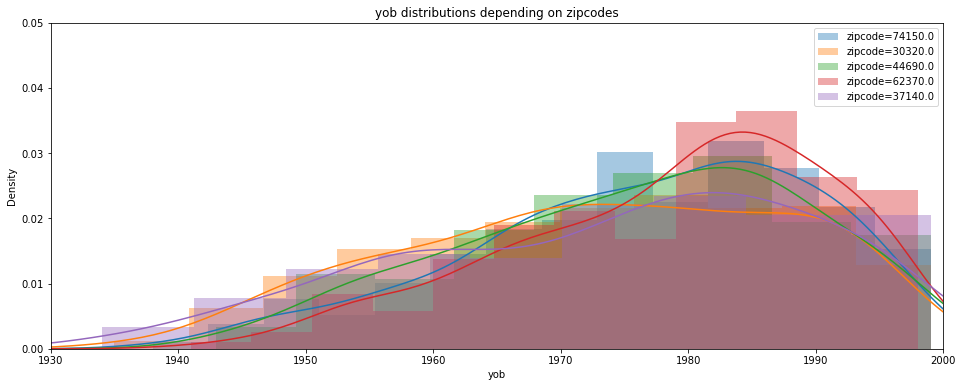

In [14]:
plt.figure(figsize=(16,6))
for zipcode in random.sample(list(zipcodes), 5):
    sns.distplot(df[(df['zipcode']==zipcode) & (df['yob'] >= 1930)]['yob'].dropna(), label=f'{zipcode=}')
plt.title('yob distributions depending on zipcodes')
plt.xlim([1930, 2000])
plt.ylim([0, 0.05])
plt.legend()
;

Here, zipcodes seem to behave to same way in terms of yob. We can try to only keep the "département" and not the whole zipcode.

''

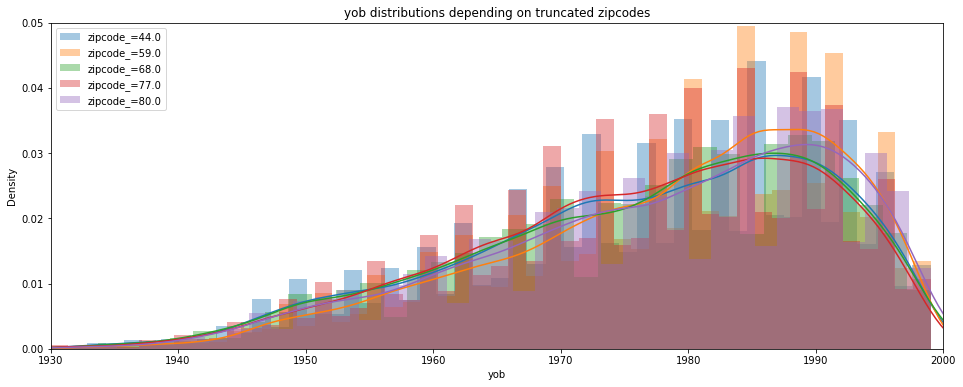

In [15]:
df['zipcode_'] = df['zipcode'].apply(lambda x: float(str(x)[:2]) if str(x)[:2] != 'na' else np.nan)
zipcodes_ = df['zipcode_'].unique()

plt.figure(figsize=(16,6))
for zipcode_ in random.sample(list(zipcodes_), 5):
    sns.distplot(df[(df['zipcode_']==zipcode_) & (df['yob'] >= 1930)]['yob'].dropna(), label=f'{zipcode_=}')
plt.title('yob distributions depending on truncated zipcodes')
plt.xlim([1930, 2000])
plt.ylim([0, 0.05])
plt.legend()
;

After trying on a few random samples of zipcodes, it seems even the "département" does not contain much information about the yob.

In [16]:
df.drop('zipcode_', axis=1, inplace=True)

Now, let's see the influence of the gender on the yob. We could suppose that it does not have such an impact on it, if the dataset is well balanced.

''

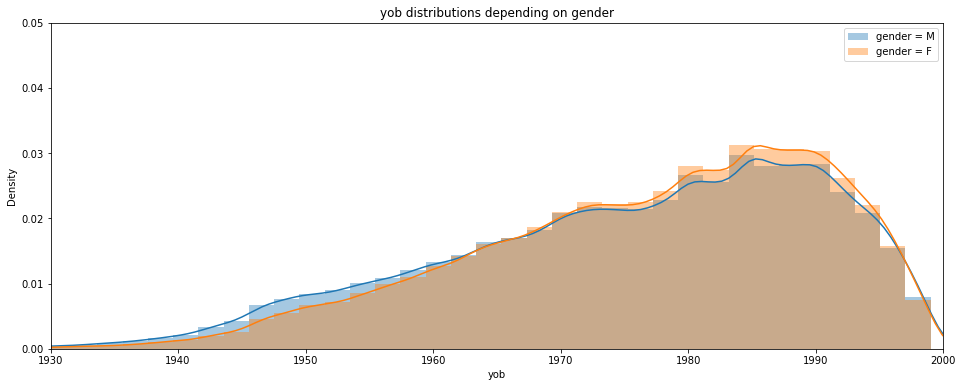

In [17]:
plt.figure(figsize=(16,6))
sns.distplot(df[df['gender']=='M']['yob'].dropna(), label='gender = M')
sns.distplot(df[df['gender']=='F']['yob'].dropna(), label='gender = F')
plt.title('yob distributions depending on gender')
plt.xlim([1930, 2000])
plt.ylim([0, 0.05])
plt.legend()
;

Our hypothesis is confirmed : gender does not seem to have an influence on the year of birth.

## Regression

We want to predict the year of birth, based on our predictor features (firstname, zipcode, gender, domain). We will accomplish a regression, and will implement two different models : a random forest and a neural network.

In [27]:
#predictor features
X = df.dropna().drop('yob', axis=1).values
#target feature
y = df.dropna()['yob'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(f'{X_train.shape = }\t {X_test.shape = }')
print(f'{y_train.shape = }\t {y_test.shape = }')

X_train.shape = (832422, 4)	 X_test.shape = (356753, 4)
y_train.shape = (832422,)	 y_test.shape = (356753,)


### Random Forest

We will first try a random forest regressor. We have to label encode some of our features, because our model cannot work with strings.

#### Label Encoding

This encoding will attribute an integer for each possible value of a given feature. We will encode domain, firstname and gender.

In [28]:
domains_dic = {domain: i for i, domain in enumerate(domains)}
X_train[:,0] = np.array(list(map((lambda x: domains_dic[x]), X_train[:,0])))
X_test[:,0] = np.array(list(map((lambda x: domains_dic[x]), X_test[:,0])))

firstnames_dic = {firstname: i for i, firstname in enumerate(firstnames)}
X_train[:,1] = np.array(list(map((lambda x: firstnames_dic[x]), X_train[:,1])))
X_test[:,1] = np.array(list(map((lambda x: firstnames_dic[x]), X_test[:,1])))

genders_dic = {gender: i for i, gender in enumerate(genders)}
X_train[:,3] = np.array(list(map((lambda x: genders_dic[x]), X_train[:,3])))
X_test[:,3] = np.array(list(map((lambda x: genders_dic[x]), X_test[:,3])))

In [29]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
rf.fit(X_train, y_train);

#### Random Forest : test results

In [30]:
pred_rf = rf.predict(X_test)

MAE_rf = np.mean(abs(pred_rf - y_test))
MSE_rf = np.sqrt(np.mean((pred_rf - y_test)**2))

print(f'MAE = {np.round(MAE_rf, 2)}')
print(f'MSE = {np.round(MSE_rf, 2)}')

MAE = 8.52
MSE = 11.72


### Neural Network

After our random forest regressor, we might try another type of regression model. We choose a neural network, with two hidden layers. This makes a lot of parameters to learn, so we have to make sure our input dimension is not extremely big.

#### Dimensionality reduction : KMeans clustering

Label encoding is not a great way to encode data for a NN. We have to use a One Hot Encoding (OHE).
This method of encoding will create n new features, if n is the number of possible values of a given fieature. In our case, this would leave us with an input dimension of dozens of thousands, which wis obviously too big to train our network.

This is why we need to reduce dimensionality. To do this, we will create clusters for each feature, and assign the cluster instead of the initial value.
We choose the KMeans method for our clustering.

##### KMeans : firstnames

In [31]:
firstname_dists = {firstname:{year:0 for year in yobs} for firstname in firstnames}
for firstname, d in firstname_dists.items():
    temp_df = df[(df['firstname']==firstname) & (df['yob'] >= 1930)]['yob'].dropna()
    counts = temp_df.value_counts()
    for year in yobs:
        if year in counts.index:
            firstname_dists[firstname][year] = firstname_dists[firstname][year] + counts[year]/sum(counts)

In [32]:
Y = [list(firstname_dists[firstname].values()) for firstname in firstnames]

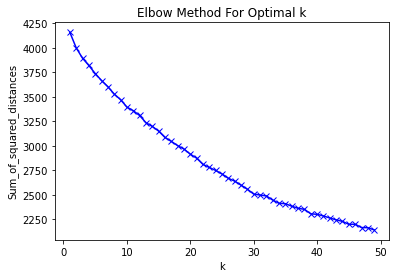

In [33]:
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Y)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We cannot find any optimal value for k. We choose k = 30, because having it too high might make our NN too long to train.

In [34]:
kmeans = KMeans(n_clusters=30)
kmeans.fit(Y)

labels = kmeans.labels_

label_dict = {firstnames[i]: labels[i] for i in range(len(labels))}
    
df['firstname_cluster'] = df['firstname'].apply(lambda x: str(label_dict[x]))

##### KMeans : domains

In [35]:
domain_dists = {domain:{year:0 for year in yobs} for domain in domains}
for domain, d in domain_dists.items():
    temp_df = df[(df['domain']==domain) & (df['yob'] >= 1930)]['yob'].dropna()
    counts = temp_df.value_counts()
    for year in yobs:
        if year in counts.index:
            domain_dists[domain][year] = domain_dists[domain][year] + counts[year]/sum(counts)

In [36]:
Y = [list(domain_dists[domain].values()) for domain in domains]

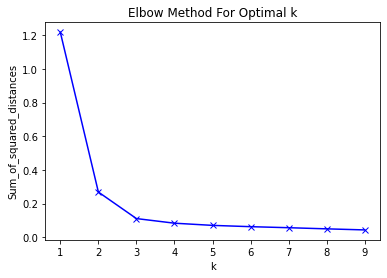

In [37]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Y)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Here, we choose k = 3 using the elbow method.

In [38]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(Y)

labels = kmeans.labels_
label_dict = {domains[i]: labels[i] for i in range(len(labels))}
    
df['domain_cluster'] = df['domain'].apply(lambda x: str(label_dict[x]))

##### KMeans : zipcodes

In [39]:
zipcode_dists = {zipcode:{year:0 for year in yobs} for zipcode in zipcodes}
for zipcode, d in zipcode_dists.items():
    temp_df = df[(df['zipcode']==zipcode) & (df['yob'] >= 1930)]['yob'].dropna()
    counts = temp_df.value_counts()
    for year in yobs:
        if year in counts.index:
            zipcode_dists[zipcode][year] = zipcode_dists[zipcode][year] + counts[year]/sum(counts)

In [40]:
Y = [list(zipcode_dists[zipcode].values()) for zipcode in zipcodes if math.isnan(zipcode)==False]

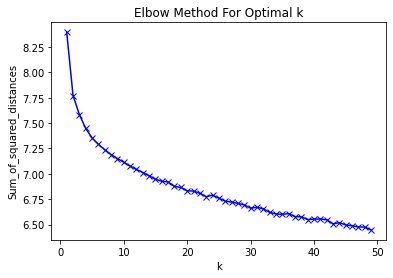

In [41]:
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Y)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

For the zipcodes, we choose k = 20.

In [42]:
kmeans = KMeans(n_clusters=20)
kmeans.fit(Y)

labels = kmeans.labels_

label_dict = {zipcodes[i]: labels[i] for i in range(len(labels))}
    
df['zipcode_cluster'] = df['zipcode'].apply(lambda x: str(label_dict[x]) if (math.isnan(x)==False and x in label_dict.keys()) else np.nan)

#### One Hot Encoding

Now that we have new features to replace the one we had, and that we reduced dimensionality, it is time on OHE our data.

In [43]:
new = df.drop(['domain', 'firstname', 'zipcode', 'gender'], axis=1).dropna()
new_na = df.loc[df['yob'].isnull(), :].drop(['firstname', 'zipcode', 'domain', 'gender'], axis=1)

X = pd.get_dummies(new.drop('yob', axis=1)).values
y = new['yob'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(f'{X_train.shape = }\t {X_test.shape = }')
print(f'{y_train.shape = }\t {y_test.shape = }')

X_train.shape = (832600, 53)	 X_test.shape = (356829, 53)
y_train.shape = (832600,)	 y_test.shape = (356829,)


#### Model architecture

In [44]:
nn = Sequential()
nn.add(Dense(50, input_dim=X.shape[1], activation= "relu"))
nn.add(Dense(10, activation= "relu"))
nn.add(Dense(10, activation= "relu"))
nn.add(Dense(1))
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2700      
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,331
Trainable params: 3,331
Non-trainable params: 0
_________________________________________________________________


In [53]:
nn.compile(loss= "mean_squared_error", metrics=["mean_squared_error", "mean_absolute_error"])
nn.fit(X_train, y_train, epochs=5)

Epoch 1/5
26019/26019 [==============================] - 43s 2ms/step - loss: 167.3495 - mean_squared_error: 167.3495 - mean_absolute_error: 9.8954
Epoch 2/5
26019/26019 [==============================] - 34s 1ms/step - loss: 166.8071 - mean_squared_error: 166.8071 - mean_absolute_error: 9.8729
Epoch 3/5
26019/26019 [==============================] - 37s 1ms/step - loss: 166.2932 - mean_squared_error: 166.2932 - mean_absolute_error: 9.8553
Epoch 4/5
26019/26019 [==============================] - 41s 2ms/step - loss: 166.5065 - mean_squared_error: 166.5065 - mean_absolute_error: 9.8622
Epoch 5/5
26019/26019 [==============================] - 44s 2ms/step - loss: 166.1626 - mean_squared_error: 166.1626 - mean_absolute_error: 9.8513


#### Neural Network : test results

In [55]:
pred_nn = nn.predict(X_test)

MAE_nn = mean_absolute_error(y_test, pred_nn)
MSE_nn = np.sqrt(mean_squared_error(y_test, pred_nn))

print(f'MAE = {np.round(MAE_nn, 2)}')
print(f'MSE = {np.round(MSE_nn, 2)}')

MAE = 8.81
MSE = 12.04


### Model comparison

In [56]:
res = pd.DataFrame(np.array([[MAE_rf, MSE_rf],
                             [MAE_nn, MSE_nn]]), 
                   columns=['MAE', 'MSE'], 
                   index=['rf', 'nn'])
display(res.applymap(lambda x: np.round(x, 4)))

,MAE,MSE
rf,8.5189,11.7198
nn,8.8139,12.0362


We have almost the same errors on the test data (X_test, y_test).
Thus, both our models have similar performances.

An idea could be to take the mean of both predictions (pred_rf and pred_nn), so that we have a more accurate prediction of the year of birth.

## Prediction results

In [57]:
original_data = pd.read_csv('user_exo_2M.csv')

X_na_rf = df.loc[df['yob'].isnull(), ['domain',	'firstname', 'zipcode', 'gender']].values
X_na_rf[:,0] = np.array(list(map((lambda x: domains_dic[x]), X_na_rf[:,0])))
X_na_rf[:,1] = np.array(list(map((lambda x: firstnames_dic[x]), X_na_rf[:,1])))
X_na_rf[:,2] = np.array(list(map((lambda x: x if math.isnan(x)==False else -1), X_na_rf[:,2])))
X_na_rf[:,3] = np.array(list(map((lambda x: genders_dic[x] if type(x)!=float else 2), X_na_rf[:,3])))
X_na_nn = pd.get_dummies(new_na.drop('yob', axis=1))

Y_na_rf = rf.predict(X_na_rf)
Y_na_nn = nn.predict(X_na_nn)

In [58]:
Y_na_df = pd.DataFrame(columns=['rf', 'nn'])
Y_na_df['rf'] = Y_na_rf
Y_na_df['nn'] = Y_na_nn
Y_na_df.to_csv('predictions.csv', index=False)

In [156]:
Y_na = pd.read_csv('predictions.csv')
Y_na['diff'] = (Y_na_df['rf'] - Y_na_df['nn']).map(abs)
Y_na['mean'] = (Y_na_df['rf'] + Y_na_df['nn']).map(lambda x: int(np.round(x/2,0)))
   
out = df.loc[:, ['yob', 'domain', 'firstname', 'gender']].copy()
out.loc[out['yob'].isnull(), 'yob'] = Y_na['mean'].values
out['yob'] = out['yob'].astype(int)

In [157]:
display(out)

,yob,domain,firstname,gender
0,1985,@wanadoo.fr,b08253b305fb5ec,F
1,1961,@sfr.fr,7ff135854376850,M
2,1977,@free.fr,172522ec1028ab7,M
3,1976,@hotmail.com,d3ca5dde60f88db,M
4,1986,@gmail.com,bdaae16837dd576,M
...,...,...,...,...
1999995,1994,@gmail.com,09f96867a8dc816,M
1999996,1997,@gmail.com,823fec7a2632ea7,F
1999997,1998,@gmail.com,029f0f59eba0903,F
1999998,1984,@hotmail.com,deb97a759ee7b8b,M


count    2.000000e+06
mean     1.974940e+03
std      3.136691e+01
min      1.484000e+03
25%      1.968000e+03
50%      1.979000e+03
75%      1.987000e+03
max      2.001000e+03
Name: yob, dtype: float64

''

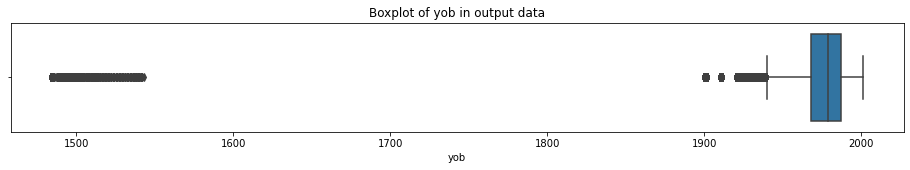

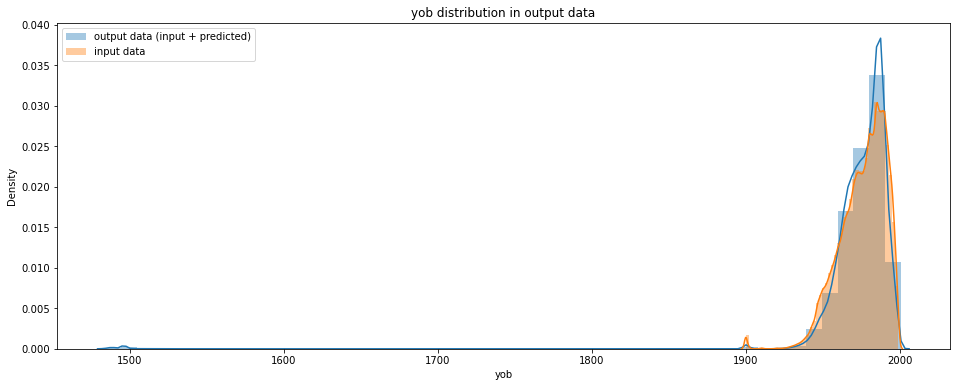

In [158]:
display(out['yob'].describe())

plt.figure(figsize=(16,2))
sns.boxplot(out['yob'])
plt.title('Boxplot of yob in output data')
;

plt.figure(figsize=(16,6))
sns.distplot(out['yob'], label='output data (input + predicted)')
sns.distplot(df['yob'], label='input data')
plt.legend()

plt.title('yob distribution in output data')
;

After visualizing our final data, we realize that there are some outliers in the year 1500. This does not make any sense. We will impute these outliers using the median.

In [159]:
med_out = Y_na['mean'].median()
med_in = df['yob'].dropna().median()
std_out = Y_na['mean'].std()
Y_na['mean'] = Y_na['mean'].map(lambda x: med_in if x < med_out-2*std else x)

In [220]:
out = df.loc[:, ['yob', 'domain', 'firstname', 'gender']].copy()
out.loc[out['yob'].isnull(), 'yob'] = Y_na['mean'].values
out['yob'] = out['yob'].astype(int)

print(f'{50*"*"} \n\t\tFINAL OUTPUT \n{50*"*"}')
display(out)

************************************************** 
		FINAL OUTPUT 
**************************************************


,yob,domain,firstname,gender
0,1985,@wanadoo.fr,b08253b305fb5ec,F
1,1961,@sfr.fr,7ff135854376850,M
2,1977,@free.fr,172522ec1028ab7,M
3,1976,@hotmail.com,d3ca5dde60f88db,M
4,1986,@gmail.com,bdaae16837dd576,M
...,...,...,...,...
1999995,1994,@gmail.com,09f96867a8dc816,M
1999996,1997,@gmail.com,823fec7a2632ea7,F
1999997,1998,@gmail.com,029f0f59eba0903,F
1999998,1984,@hotmail.com,deb97a759ee7b8b,M


Let's visualize our corrected output data (boxplot, distplot, descriptive statistics) in order to validate it.

count    2.000000e+06
mean     1.976640e+03
std      1.312229e+01
min      1.900000e+03
25%      1.968000e+03
50%      1.979000e+03
75%      1.987000e+03
max      2.001000e+03
Name: yob, dtype: float64

''

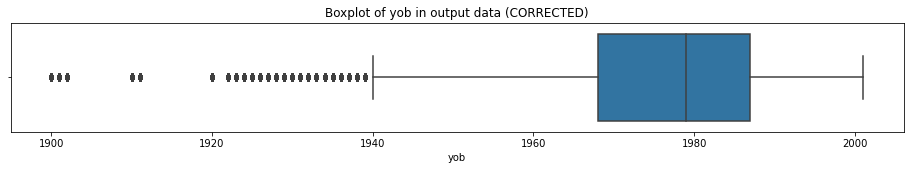

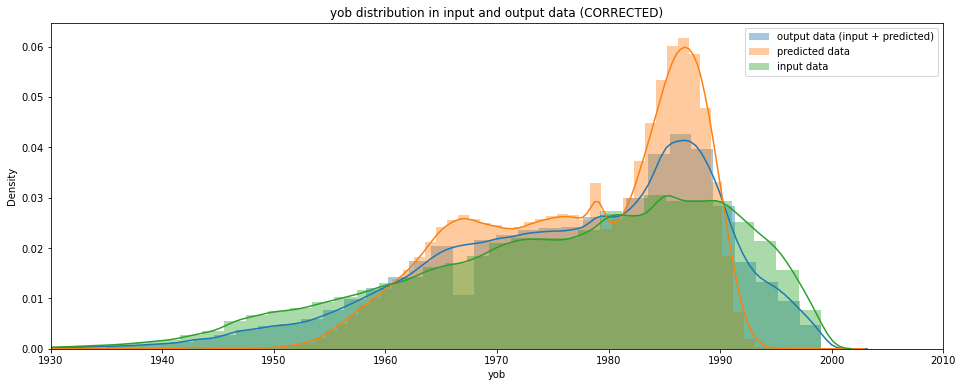

In [190]:
display(out['yob'].describe())

plt.figure(figsize=(16,2))
sns.boxplot(out['yob'])
plt.title('Boxplot of yob in output data (CORRECTED)')
;

plt.figure(figsize=(16,6))
sns.distplot(out['yob'], bins=52, label='output data (input + predicted)')
sns.distplot(Y_na['mean'].values, bins=70, label='predicted data')
sns.distplot(df['yob'], bins=50, label='input data')
plt.legend()
plt.xlim([1930, 2010])

plt.title('yob distribution in input and output data (CORRECTED)')
;

Now, our distributions are much more alike. We will keep this as our final output dataset.

In [138]:
out.to_csv('user_completed.csv', index=False)

Out of curiosity, let's compare the year of birth distributions our models gave, separately.

''

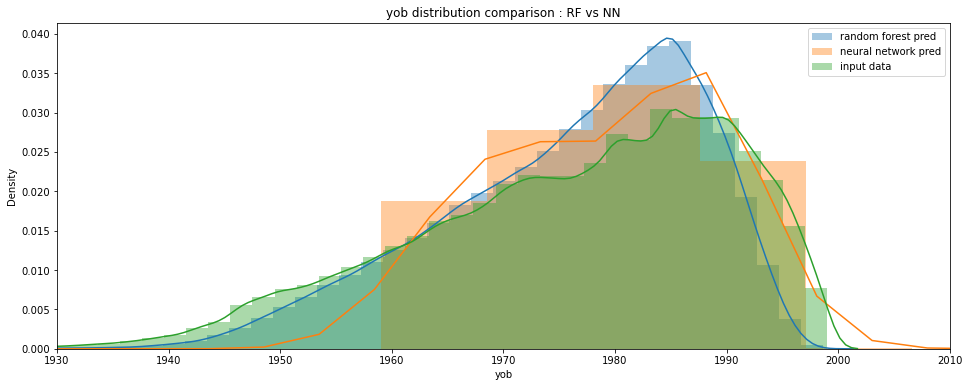

In [221]:
plt.figure(figsize=(16,6))
sns.distplot(Y_na_rf, label='random forest pred')
sns.distplot(Y_na_nn, bins=100, label='neural network pred')
sns.distplot(df['yob'], label='input data')
plt.title('yob distribution comparison : RF vs NN')
plt.xlim([1930, 2010])
plt.legend()
;

Our neural network gives much less sparse values than our random forest. Maybe it was a better idea to only keep the RF, and not to compute the mean with the NN.

## Improvements
A few improvements could be made for our year of birth prediction.

### Dimensionality Reduction
First, we could improve our dimensionality reduction. We used a clustering method (KMeans), which can be optimized. Also, other clustering methods and dim reduction exist.

#### KMeans
We chose the value of k = n_clusters using the elbow method. Though, it might be interesting to tune k as an hyperparameter for our RF or NN. We could then choose the value of K which minimizes the loss of our regressors.

It could also be possible to choose another metric instead of the Euclidean distance for our inertia calculation.

#### HCA
Instead of using the KMeans clustering method, we could use a Hierarchical Clustering Analysis and compare the results in terms of regression loss, only to keep the best method.

#### PCA
Some features post one-hot-encoding might be correlated, and thus we could apply a Principal Component Analysis to create new features (linear combinations of existing ones).
We could select the new features having the most inertia, and only keep these for our regression.

### Regression Model
We chose two different regression models, each of these having several hyperparameters.

It is possible to either tune these hyperparameters (find the combination which minimizes loss), or use a different regression model.

#### Random Forest
Our random forest regressor has a few parameters that could be changed, as the number of estimators (currently 50). We could iterate our regression on values of estimators between 10 and 200, and pick the one with the least loss.

We could do the same thing for the max depth of the tree.

#### Neural Network
We chose a certain NN model architecure : input layer with 50 neurons, 2 hidden layers with 2 neurons each, and one output layer with 1 neuron.
Also, we chose ReLU activation functions.

This is an arbitrary choice, but we could totally change the architecure and try to find a combination which minimizes the loss. Though, we have to keep in mind that increasing the number of hidden layers or the number of neurons per layer can drastically increase the training time.

#### Other models

It could be possible to find and use another regression model.

Also, we could try to use a classification model, with each year of birth corresponding to a label. Several classification models exist, such as a Decision Tree, Random Forest, K-Nearest-Neighbors, Support Vector Machines, Naive Bayes, etc.